# Classification of Radiative Events

## Data Sets

In [1]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import numpy as np
import root_numpy as rnp
import matplotlib.pyplot as plt

## Preprocessing of Signal an Background Events

Trident's of interest are expected to be within the acceptance of both the Ecal and SVT.  This means that the electron pair is expected to leave a pair tracks in the SVT and a mathching cluster pair in the Ecal.  Because of the good time resolution of the Ecal, a cluster pair can be easily selected in an event.  The cluster pair can then be matched up to the two clusters.

These requirements will be applied at the preprocessing level.

## Preprocessed Distributions

In [2]:
# Open a ROOT file and create a record array out of both the preprocessed BH and Rad ntuples
X_rad_rec = rnp.root2array("rad_preprocessed.root")
X_bh_rec = rnp.root2array("bh_preprocessed.root")

# Convert the data into an array that can be used as an input into scikit-learn
X_rad = rnp.rec2array(X_rad_rec)
X_bh = rnp.rec2array(X_bh_rec)

print "Length of Rad array: " + str(len(X_rad))
print "Shape of Rad array: " + str(X_rad.shape)
print "Length of BH array: " + str(len(X_bh))
print "Shape of BH array: " + str(X_bh.shape)

Length of Rad array: 219535
Shape of Rad array: (219535, 26)
Length of BH array: 12131
Shape of BH array: (12131, 26)


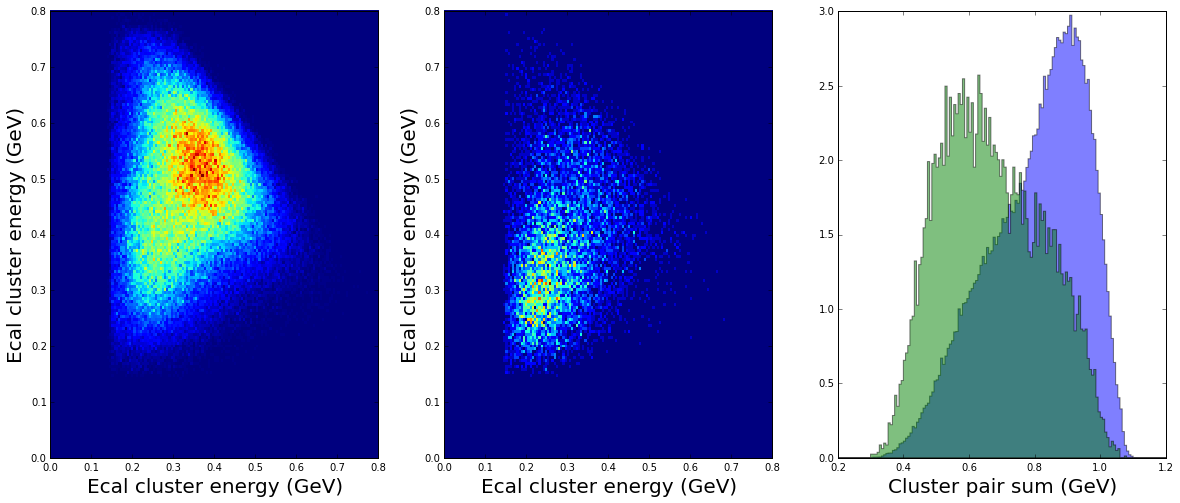

In [3]:
rad_cluster_0_energy = X_rad_rec['cluster_0_energy']
rad_cluster_1_energy = X_rad_rec['cluster_1_energy']
bh_cluster_0_energy = X_bh_rec['cluster_0_energy']
bh_cluster_1_energy = X_bh_rec['cluster_1_energy']

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,8))

ax0.hist2d(rad_cluster_0_energy, rad_cluster_1_energy, bins=150, range=[[0, 0.8], [0, 0.8]]);
ax0.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax0.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)

ax1.hist2d(bh_cluster_0_energy, bh_cluster_1_energy, bins=150, range=[[0, 0.8], [0, 0.8]]);
ax1.set_xlabel("Ecal cluster energy (GeV)", fontsize=20)
ax1.set_ylabel("Ecal cluster energy (GeV)", fontsize=20)

ax2.hist(rad_cluster_0_energy+rad_cluster_1_energy, bins=150, range=(0.2, 1.2), alpha=0.5, normed=True, histtype="stepfilled");
ax2.hist(bh_cluster_0_energy+bh_cluster_1_energy, bins=150, range=(0.2, 1.2), alpha=0.5, normed=True, histtype="stepfilled");
ax2.set_xlabel("Cluster pair sum (GeV)", fontsize=20)

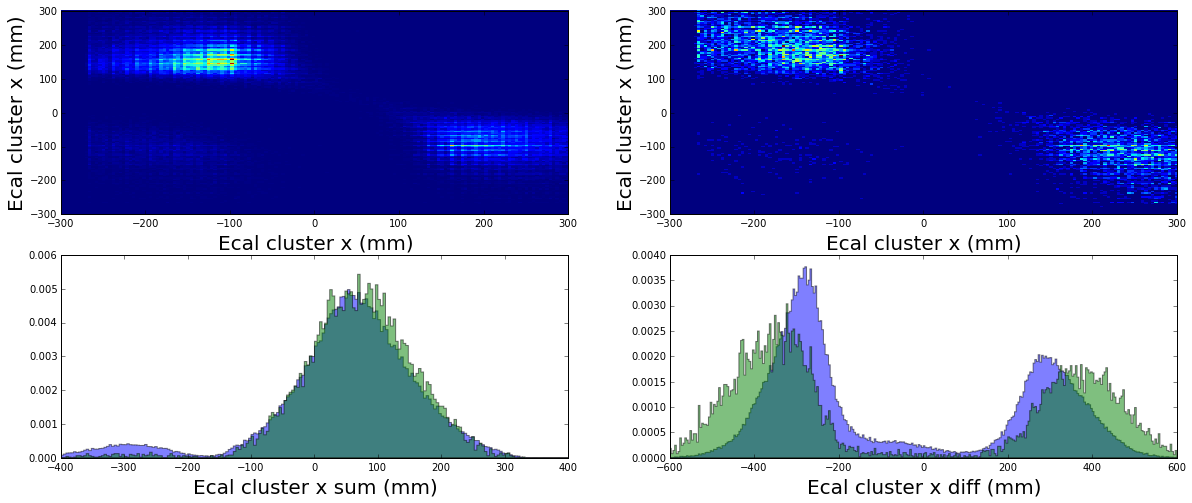

In [4]:
rad_cluster_0_x = X_rad_rec['cluster_0_x']
rad_cluster_1_x = X_rad_rec['cluster_1_x']
bh_cluster_0_x = X_bh_rec['cluster_0_x']
bh_cluster_1_x = X_bh_rec['cluster_1_x']

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
ax0.hist2d(rad_cluster_0_x, rad_cluster_1_x, bins=150, range=[[-300, 300], [-300, 300]])
ax0.set_xlabel("Ecal cluster x (mm)", fontsize=20)
ax0.set_ylabel("Ecal cluster x (mm)", fontsize=20)

ax1.hist2d(bh_cluster_0_x, bh_cluster_1_x, bins=150, range=[[-300, 300], [-300, 300]])
ax1.set_xlabel("Ecal cluster x (mm)", fontsize=20)
ax1.set_ylabel("Ecal cluster x (mm)", fontsize=20)

ax2.hist(rad_cluster_0_x + rad_cluster_1_x, bins=200, range=(-400, 400), alpha=0.5, normed=True, histtype="stepfilled")
ax2.hist(bh_cluster_0_x + bh_cluster_1_x, bins=200, range=(-400, 400), alpha=0.5, normed=True, histtype="stepfilled");
ax2.set_xlabel("Ecal cluster x sum (mm)", fontsize=20)

ax3.hist(rad_cluster_0_x - rad_cluster_1_x, bins=300, range=(-600, 600), alpha=0.5, normed=True, histtype="stepfilled")
ax3.hist(bh_cluster_0_x - bh_cluster_1_x, bins=300, range=(-600, 600), alpha=0.5, normed=True, histtype="stepfilled")
ax3.set_xlabel("Ecal cluster x diff (mm)", fontsize=20)

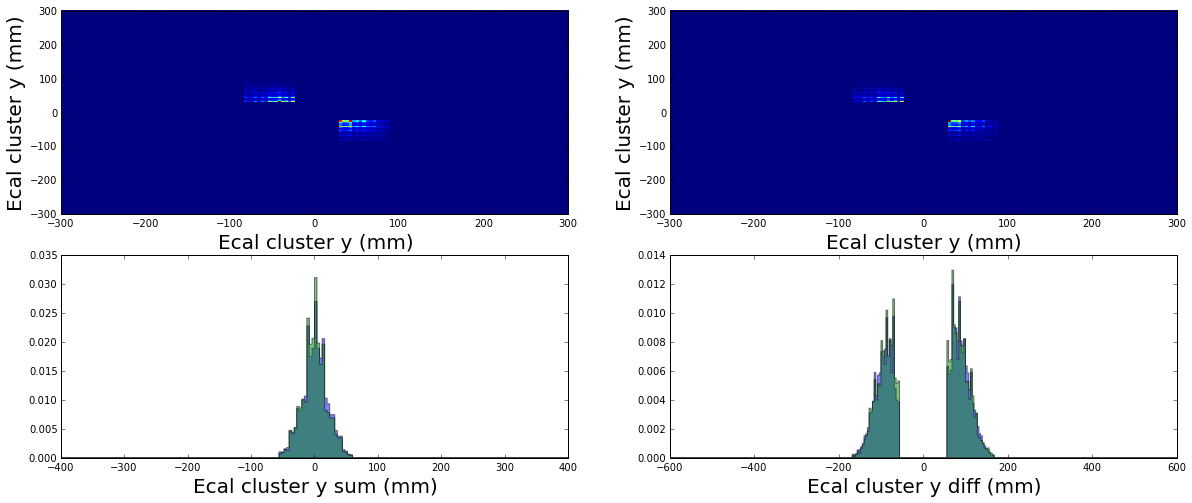

In [5]:
rad_cluster_0_y = X_rad_rec['cluster_0_y']
rad_cluster_1_y = X_rad_rec['cluster_1_y']
bh_cluster_0_y = X_bh_rec['cluster_0_y']
bh_cluster_1_y = X_bh_rec['cluster_1_y']

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
ax0.hist2d(rad_cluster_0_y, rad_cluster_1_y, bins=150, range=[[-300, 300], [-300, 300]])
ax0.set_xlabel("Ecal cluster y (mm)", fontsize=20)
ax0.set_ylabel("Ecal cluster y (mm)", fontsize=20)

ax1.hist2d(bh_cluster_0_y, bh_cluster_1_y, bins=150, range=[[-300, 300], [-300, 300]])
ax1.set_xlabel("Ecal cluster y (mm)", fontsize=20)
ax1.set_ylabel("Ecal cluster y (mm)", fontsize=20)

ax2.hist(rad_cluster_0_y + rad_cluster_1_y, bins=200, range=(-400, 400), alpha=0.5, normed=True, histtype="stepfilled")
ax2.hist(bh_cluster_0_y + bh_cluster_1_y, bins=200, range=(-400, 400), alpha=0.5, normed=True, histtype="stepfilled");
ax2.set_xlabel("Ecal cluster y sum (mm)", fontsize=20)

ax3.hist(rad_cluster_0_y - rad_cluster_1_y, bins=300, range=(-600, 600), alpha=0.5, normed=True, histtype="stepfilled")
ax3.hist(bh_cluster_0_y - bh_cluster_1_y, bins=300, range=(-600, 600), alpha=0.5, normed=True, histtype="stepfilled")
ax3.set_xlabel("Ecal cluster y diff (mm)", fontsize=20)

In [6]:
y_rad = np.ones(len(X_rad))
y_bh = np.zeros(len(X_bh))

rad_zip = zip(X_rad, y_rad)
bh_zip = zip(X_bh, y_bh)

X_merge = np.concatenate((rad_zip, bh_zip))
np.random.shuffle(X_merge)

X_list, y_list = map(list, zip(*X_merge))

X = np.array(X_list)
print "Shape of X: " + str(X.shape)

y = np.array(y_list)
print "Shape of y: " + str(y.shape)

Shape of X: (231666, 26)
Shape of y: (231666,)


## Decision Tree

In [7]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier(max_depth=20)

In [ ]:
from sklearn import cross_validation

scores = cross_validation.cross_val_score(tree_clf, X, y, cv=20)

In [ ]:
scores.mean()